In [1]:
#importing general libraries
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory
from teachopencadd.utils import seed_everything

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import Descriptors, Draw, PandasTools
from rdkit.ML.Cluster import Butina

from matplotlib.lines  import Line2D
import matplotlib.patches as mpatches

In [4]:
#directory handling
here = Path(_dh[-1])
DATA = here/"DATA"

In [41]:
#importing database
molecules_sirt2 = pd.read_excel("sirtuin2_human_chembl_ic50_raw.xlsx")

#setting str to lower in columns
molecules_sirt2.columns = molecules_sirt2.columns.str.lower()

In [42]:
molecules_sirt2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1626 entries, 0 to 1625
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   molecule chembl id          1626 non-null   object 
 1   molecule name               88 non-null     object 
 2   molecule max phase          1626 non-null   int64  
 3   molecular weight            1626 non-null   float64
 4   #ro5 violations             1626 non-null   object 
 5   alogp                       1626 non-null   object 
 6   compound key                1625 non-null   object 
 7   smiles                      1626 non-null   object 
 8   standard type               1626 non-null   object 
 9   standard relation           1326 non-null   object 
 10  standard value              1326 non-null   float64
 11  standard units              1326 non-null   object 
 12  pchembl value               1100 non-null   float64
 13  data validity comment       141 n

In [43]:
#selecting only the columns needed

molecules_sirt2 = molecules_sirt2.loc[:, ["molecule chembl id", "compound key", "smiles", "standard type", "standard relation",
                       "standard value", "standard units", "assay chembl id", "assay type",
                        "target chembl id", "target name", "target organism"
                       ]]

In [54]:

#dropping the na/nan values
molecules_sirt2 = molecules_sirt2.dropna(axis = 0, how = "any")
#we are left with 1325

In [59]:
#dropping duplicates
molecules_sirt2 = molecules_sirt2.drop_duplicates("molecule chembl id")
#we are left with exactly 1000 molecules

In [62]:
molecules_sirt2.shape

(1000, 12)

In [64]:
PandasTools.AddMoleculeColumnToFrame(molecules_sirt2, "smiles")

,molecule chembl id,compound key,smiles,standard type,standard relation,standard value,standard units,assay chembl id,assay type,target chembl id,target name,target organism,ROMol
0,CHEMBL218328,12i,CN1CCCC1CCn1cc(C2=C(c3c[nH]c4ccccc34)C(=O)NC2=...,IC50,'=',8300.0,nM,CHEMBL909821,B,CHEMBL4462,NAD-dependent deacetylase sirtuin 2,Homo sapiens,
1,CHEMBL218910,12e,O=C1NC(=O)C(c2c[nH]c3cccc(F)c23)=C1c1cn(CCOC(C...,IC50,'=',9500.0,nM,CHEMBL909821,B,CHEMBL4462,NAD-dependent deacetylase sirtuin 2,Homo sapiens,
2,CHEMBL430574,"15b, paullone",O=C1Cc2c([nH]c3ccccc23)-c2ccccc2N1,IC50,'=',10000.0,nM,CHEMBL909830,B,CHEMBL4462,NAD-dependent deacetylase sirtuin 2,Homo sapiens,
3,CHEMBL3580806,19,N#Cc1ccc(NC(=O)c2cccc([S+]([O-])Cc3ccc(Cl)cc3)...,IC50,'=',7100.0,nM,CHEMBL3582613,B,CHEMBL4462,NAD-dependent deacetylase sirtuin 2,Homo sapiens,
4,CHEMBL4632398,27c,O=C1N/C(=C\c2ccc(N3CCCC3)cc2)C(=O)N1Cc1ccc(Cl)cc1,IC50,'=',38800.0,nM,CHEMBL4613362,B,CHEMBL4462,NAD-dependent deacetylase sirtuin 2,Homo sapiens,

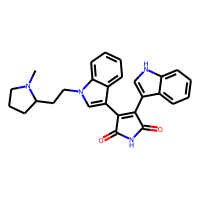
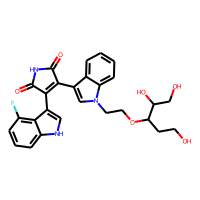
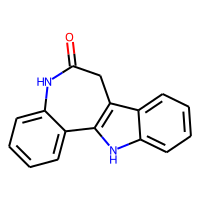
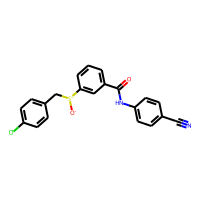
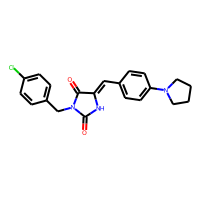

In [65]:
molecules_sirt2.head()

In [66]:
#calculating descriptors

molecules_sirt2["mw"] = molecules_sirt2["ROMol"].apply(Descriptors.ExactMolWt)
molecules_sirt2["n_hba"] = molecules_sirt2["ROMol"].apply(Descriptors.NumHAcceptors)
molecules_sirt2["n_hbd"] = molecules_sirt2["ROMol"].apply(Descriptors.NumHDonors)
molecules_sirt2["logp"] = molecules_sirt2["ROMol"].apply(Descriptors.MolLogP)

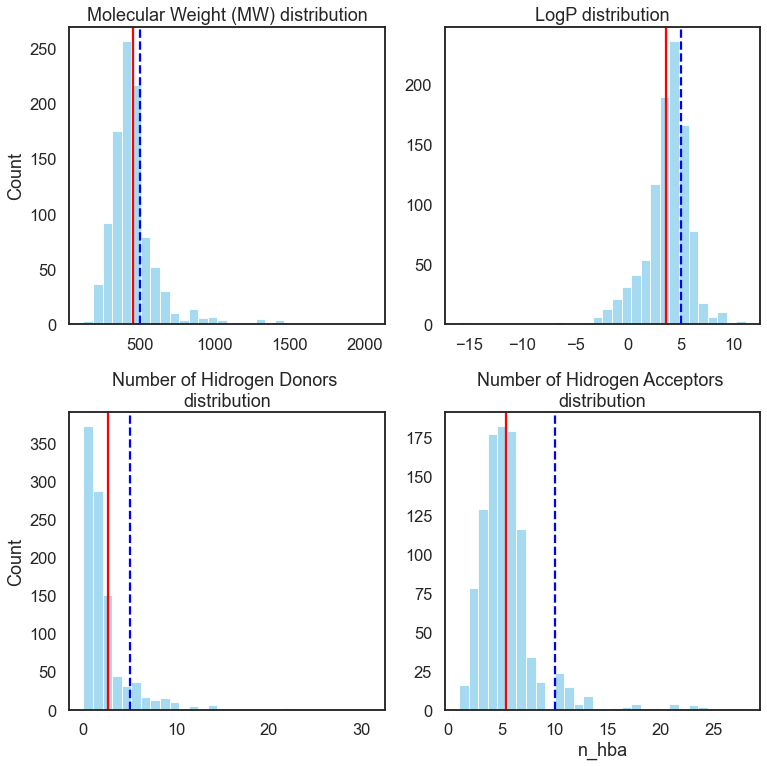

In [80]:
#plotting the distribution of sirtuin 2 inhibitors calculated descriptors


import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
sns.set_context("talk")

fig, axs = plt.subplots(2,2, figsize = (11,11))

sns.histplot(data = molecules_sirt2, x = "mw", kde = False, color = "skyblue",
            ax = axs[0,0], bins = 30).set(title = "Molecular Weight (MW) distribution", xlabel = "")
axs[0,0].axvline(molecules_sirt2.mw.mean(), color = "red")
axs[0,0].axvline(500, color = "blue", linestyle = "--") #max lipinski

#plot logp
sns.histplot(data = molecules_sirt2, x = "logp", kde = False, color = "skyblue",
             ax = axs[0,1], bins = 30).set(title = "LogP distribution", xlabel = "",
                                          ylabel = "")
axs[0,1].axvline(molecules_sirt2.logp.mean(), color = "red")
axs[0,1].axvline(5, color = "blue", linestyle = "--") #logp max lipinski

#plot number of h donors
sns.histplot(data = molecules_sirt2, x = "n_hbd", kde = False, color = "skyblue",
            ax = axs[1,0], bins = 30).set(title = "Number of Hidrogen Donors \ndistribution", xlabel = "")
axs[1,0].axvline(molecules_sirt2.n_hbd.mean(), color = "red")
axs[1,0].axvline(5, color = "blue", linestyle = "--") #number of h donors lipinski


#plot number of h acceptors
sns.histplot(data = molecules_sirt2, x = "n_hba", kde = False, color = "skyblue",
            ax = axs[1,1], bins = 30).set(title = "Number of Hidrogen Acceptors \ndistribution", ylabel = "")
axs[1,1].axvline(molecules_sirt2.n_hba.mean(), color = "red")
axs[1,1].axvline(10, color = "blue", linestyle = "--") #number of h acceptors

fig.tight_layout()

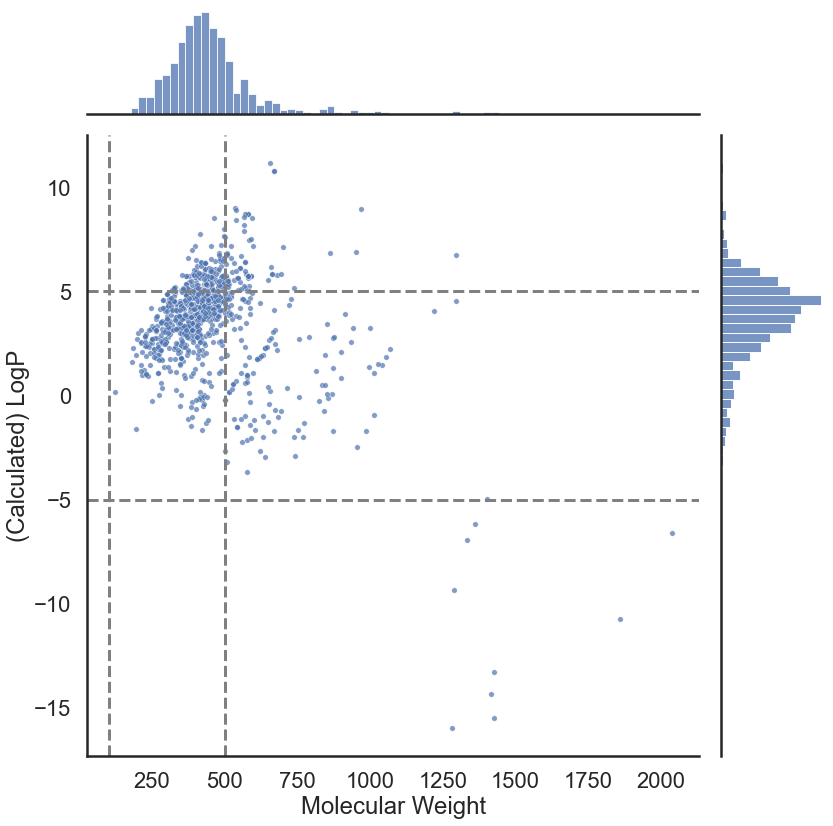

In [96]:
sns.set(style = "white")
sns.set_context("poster")

mw_logp_plt = sns.jointplot(x = "mw", y = "logp", data = molecules_sirt2,
                           alpha = 0.7, height = 12, s =30).set_axis_labels(
    "Molecular Weight", "(Calculated) LogP")
mw_logp_plt.ax_joint.axvline(500, linestyle = "--", color = "grey")
mw_logp_plt.ax_joint.axvline(100, linestyle = "--",color = "grey")
mw_logp_plt.ax_joint.axhline(5, color = "grey", linestyle = "--")
mw_logp_plt.ax_joint.axhline(-5, color = "grey", linestyle = "--")